# 主程式

## 前處理

掛載goole雲端

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

資料載入及指標汙染物index提取

In [ ]:
import pandas as pd
import numpy as np

#### 資料集載入
filepath = '/content/drive/MyDrive/博班資料/課程資料/物聯網數據分析與應用/Project/data.csv'
df = pd.read_csv( filepath )
index = df.columns.tolist()

#### 指標汙染物擷取
obj = list(df[index[2]])
obj = list(set(obj))
obj.remove('WIND_DIREC          ')
obj.remove('RAINFALL            ')
obj.remove('NMHC                ')
obj.remove('WD_HR               ')
obj.remove('AMB_TEMP            ')
obj.remove('RH                  ')
obj.remove('THC                 ')
obj.remove('--------------------')
obj.remove('WS_HR               ')
obj.remove('WIND_SPEED          ')
obj.remove('CH4                 ')
obj.remove('NOx                 ')
obj.remove('NO                  ')
obj = ['O3                  ', 'NO2                 ', 'CO                  ', 'PM2.5               ', 'PM10                ', 'SO2                 ']
print(obj)


資料前處理(缺失值)
規則：
1. 由前兩筆資料差來計算缺失值
2. 若是缺失資料大於4則丟掉該筆資料

In [ ]:
def imputer(data):
  ###### init 
  CHECK_VALUE = 0 # 確認是否為缺失值
  index_num = 0 # 表示跳過幾個index
  tem_ary = [] # 暫存資料(筆)
  data_ary = [] # 前處理完資料
  row, col = data.shape

  for i in range(row):

    tem_ary = []
    index_num = 0
    try:
      for j in range(3, col):
        if index_num > 4:
          break
        val = data[i:i+1][index[j]]
        try:
          float(val)
          tem_ary.append(float(val))
        except:
          if j < 5:
            while CHECK_VALUE == 0:
              nex_val = data[i:i+1][index[ j + 1 + index_num ]]
              try:
                float(nex_val)
                nexx_val = data[i:i+1][index[ j + 2 + index_num ]]
                try:
                  float(nexx_val)
                  CHECK_VALUE = 1
                  sub = round(float(nexx_val) - float(nex_val), 2)
                  val = round(float(nex_val) - sub, 2)
                  tem_ary.append(val)
                except:
                  while CHECK_VALUE == 0:
                    if index_num > 4 :
                      break
                    index_num += 1
                    nexx_val == data[i:i+1][index[ j + 2 + index_num ]]
                    try:
                      float(nexx_val)
                      sub = round(float(nexx_val) - float(nex_val), 2)
                      val = round(float(nex_val) - sub, 2)
                      tem_ary.append(val)
                      CHECK_VALUE
                    except:
                      index_num += 1
              except:
                index_num += 1
                if index_num > 4:
                  break
          else:
            sub = round(tem_ary[-1] - tem_ary[-2], 2)
            val = round(sub + tem_ary[-2], 2)
            tem_ary.extend(val)
      if index_num < 5:
        data_ary.extend(tem_ary)
    except:
      pass

  return data_ary

#### 切割資料(測試用)
O3 = df[df[index[2]] == obj[0]]
NO2 = df[df[index[2]] == obj[1]]
CO = df[df[index[2]] == obj[2]]
PM25 = df[df[index[2]] == obj[3]]
PM10 = df[df[index[2]] == obj[4]]
SO2 = df[df[index[2]] == obj[5]]


O3 = imputer(O3)
NO2 = imputer(NO2)
SO2 = imputer(SO2)
CO = imputer(CO)
PM10 = imputer(PM10)
PM25 = imputer(PM25)



資料前處理(切割訓練及測試資料)

In [ ]:
#### 擷取資料
def Resize_data(data, n, aqi_t):

  #### init
  train_temp = []
  x_train = []
  y_train = []
  test_temp = []
  x_test = []
  y_test = []
  
  #### 切割資料
  train_num = round(len(data)*0.8)
  train = data[:train_num]
  test = data[train_num:]

  #### 前處理(Training Set)
  ## 依AQI時間進行處理
  for i in range( len(train)-aqi_t-1 ):
    tr_x_mean = float( round( np.mean( np.array( train[ i : i+aqi_t ] ) ), 2 ) )
    train_temp.append( tr_x_mean )
  
  #print("train_temp_len:", len(train_temp))

  for k in range( len(train_temp)-n-1 ):
    x_train.append( train_temp[ k : k+n ] )
    y_train.append( train_temp[ k+n : k+n+1 ] )

  #print("train_len:", len(x_train))


  #### 前處理(Testing Set)
  ## 依AQI時間進行處理
  for l in range( len(test)-aqi_t-1 ):
    tx_x_mean = float( round( np.mean( np.array( test[ l : l+aqi_t ] ) ), 2 ) )
    test_temp.append( tx_x_mean )

  #print("test_temp_len:", len(test_temp))

  for j in range( len(test_temp)-n-1 ):
    x_test.append( test_temp[ j : j+n ] )
    y_test.append( test_temp[ j+n : j+n+1 ] )
  
  #print("test_len:", len(x_test))
  
  return np.array(x_train), np.array(y_train), np.array(x_test), np.array(y_test)

# X_train, Y_train, X_test, Y_test = Resize_data( CO, 30, 8 )
# X_train, Y_train, X_test, Y_test = Resize_data( PM25, 30, 24 )
# X_train, Y_train, X_test, Y_test = Resize_data( PM10, 30, 24 )
# X_train, Y_train, X_test, Y_test = Resize_data( NO2, 30, 1 )
# X_train, Y_train, X_test, Y_test = Resize_data( SO2, 30, 1 )
# X_train, Y_train, X_test, Y_test = Resize_data( O3, 30, 1 )
# X_train, Y_train, X_test, Y_test = Resize_data( O3, 30, 8 )


## 模型建立(訓練及測試)

模型建立

In [ ]:
from matplotlib import pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

def build_model(optimizer):
  grid_model = Sequential()
  grid_model.add(LSTM(50,return_sequences=True,input_shape=(30,1)))
  grid_model.add(LSTM(50))
  grid_model.add(Dropout(0.2))
  grid_model.add(Dense(1))
  grid_model.compile(loss = 'mse',optimizer = optimizer)
  return grid_model

grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(X_test,Y_test))
parameters = {'batch_size' : [16,20],
           'epochs' : [8,10],
           'optimizer' : ['adam','Adadelta'] }
grid = GridSearchCV(estimator = grid_model,
                         param_grid = parameters,
                         cv = 2)


<ipython-input-9-988e703bbf7c>:18: DeprecationWarning: KerasRegressor is deprecated, use Sci-Keras (https://github.com/adriangb/scikeras) instead. See https://www.adriangb.com/scikeras/stable/migration.html for help migrating.
  grid_model = KerasRegressor(build_fn=build_model,verbose=1,validation_data=(X_test,Y_test))


優化(找尋最佳參數)

In [ ]:
grid_search = grid.fit(X_train, Y_train)

In [ ]:
grid_search.best_params_

{'batch_size': 16, 'epochs': 10, 'optimizer': 'adam'}

In [ ]:
grid_search.best_estimator_

In [ ]:
model = grid_search.best_estimator_.model

prediction = model.predict(X_test)
print(prediction.shape)

44/44 [==============================] - 1s 9ms/step
(1395, 1)


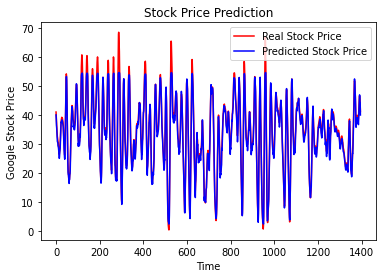

In [ ]:
plt.plot(Y_test, color = 'red', label = 'Real Stock Price')
plt.plot(prediction, color = 'blue', label = 'Predicted Stock Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Google Stock Price')
plt.savefig('/content/drive/MyDrive/博班資料/課程資料/物聯網數據分析與應用/Project/O3_8h.png')#儲存圖片
plt.legend()
plt.show()

In [ ]:
model.save('/content/drive/MyDrive/博班資料/課程資料/物聯網數據分析與應用/Project/lstm_model(O3_8h).h5')


## 預測

AQI計算

1. pre_data [ [CO, 8], [PM25, 24], [PM10, 24], [NO2, 1], [SO2, 1], [O3, 1], [O3, 8] ]
2. 建立預測資料陣列

In [ ]:
#### 預測資料
pre_index = ["CO", "PM25", "PM10", "NO2", "SO2", "O3", "O3_8h"]
pre_temp = [ [CO, 8], [PM25, 24], [PM10, 24], [NO2, 1], [SO2, 1], [O3, 1], [O3, 8] ]
pre_data = []

for pre_val, pre_range in pre_temp:
  pre_data.append( Resize_data( pre_val, 30, pre_range ) )

# X_train, Y_train, X_test, Y_test = Resize_data( CO, 30, 8 )
# X_train, Y_train, X_test, Y_test = Resize_data( PM25, 30, 24 )
# X_train, Y_train, X_test, Y_test = Resize_data( PM10, 30, 24 )
# X_train, Y_train, X_test, Y_test = Resize_data( NO2, 30, 1 )
# X_train, Y_train, X_test, Y_test = Resize_data( SO2, 30, 1 )
#　X_train, Y_train, X_test, Y_test = Resize_data( O3, 30, 1 )
# X_train, Y_train, X_test, Y_test = Resize_data( O3, 30, 8 )


建立模型陣列

In [ ]:
import tensorflow as tf

#### 模型陣列
model_ary = []

for name in pre_index:
  mdl = tf.keras.models.load_model('/content/drive/MyDrive/博班資料/課程資料/物聯網數據分析與應用/Project/lstm_model(' + name + ').h5' )
  model_ary.append(mdl)

# O3_8h_model = tf.keras.models.load_model('/content/drive/MyDrive/博班資料/課程資料/物聯網數據分析與應用/Project/lstm_model(O3_8h).h5')
# O3_model = tf.keras.models.load_model('/content/drive/MyDrive/博班資料/課程資料/物聯網數據分析與應用/Project/lstm_model(O3).h5')
# PM25_model = tf.keras.models.load_model('/content/drive/MyDrive/博班資料/課程資料/物聯網數據分析與應用/Project/lstm_model(PM25).h5')
# PM10_model = tf.keras.models.load_model('/content/drive/MyDrive/博班資料/課程資料/物聯網數據分析與應用/Project/lstm_model(PM10).h5')
# CO_model = tf.keras.models.load_model('/content/drive/MyDrive/博班資料/課程資料/物聯網數據分析與應用/Project/lstm_model(CO).h5')
# NO2_model = tf.keras.models.load_model('/content/drive/MyDrive/博班資料/課程資料/物聯網數據分析與應用/Project/lstm_model(NO2).h5')
# SO2_model = tf.keras.models.load_model('/content/drive/MyDrive/博班資料/課程資料/物聯網數據分析與應用/Project/lstm_model(SO2).h5')

建立模型預測陣列

In [ ]:
#### 模型預測值陣列
model_pre_ary = []

for m in range(len(model_ary)):
  pre_val_temp = model_ary[m].predict(pre_data[m][2])
  model_pre_ary.append(pre_val_temp)

# O3_8h_prediction = O3_8h_model.predict(X_test)
# O3_prediction = O3_model.predict(X_test)
# PM25_prediction = PM25_model.predict(X_test)
# PM10_prediction = PM10_model.predict(X_test)
# CO_prediction = CO_model.predict(X_test)
# NO2_prediction = NO2_model.predict(X_test)
# SO2_prediction = SO2_model.predict(testX)
# PM10_prediction = PM10_model.predict(pre_data[2][2])
# model_pre_ary.append(PM10_prediction)


44/44 [==============================] - 1s 9ms/step


顯示比對圖片

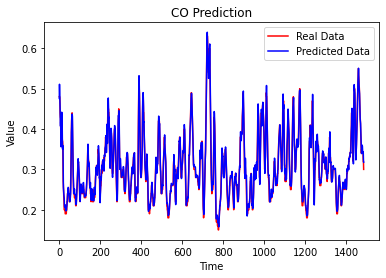

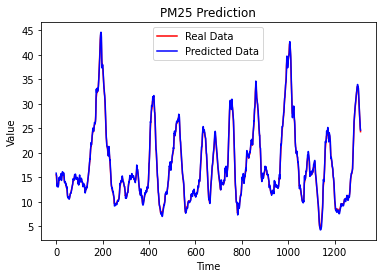

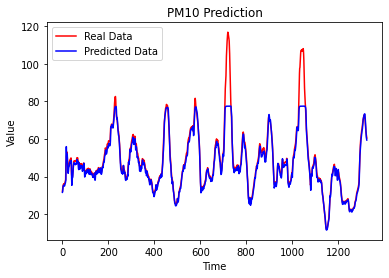

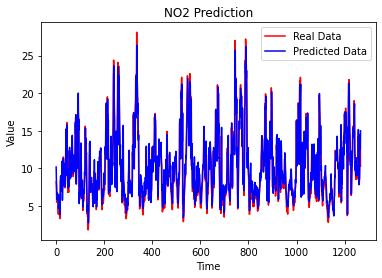

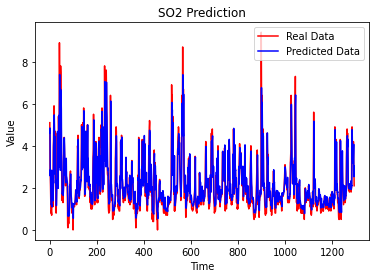

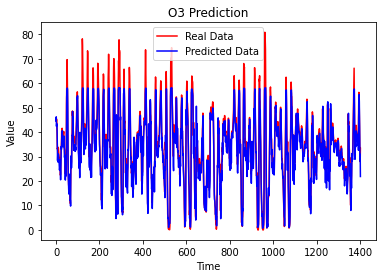

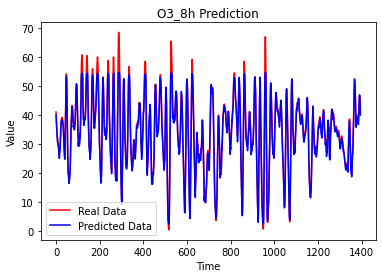

In [ ]:
from matplotlib import pyplot as plt

for a in range(len(model_pre_ary)):
  plt.plot(pre_data[a][3], color = 'red', label = 'Real Data')
  plt.plot(model_pre_ary[a], color = 'blue', label = 'Predicted Data')
  plt.title( pre_index[a] + " Prediction")
  plt.xlabel('Time')
  plt.ylabel('Value')
  # plt.savefig('/content/drive/MyDrive/博班資料/課程資料/物聯網數據分析與應用/Project/' + pre_index[a] + '.png')#儲存圖片
  plt.legend()
  plt.show()

計算 **AQI** 及 **正確率**

In [ ]:
#### 預測率(以AQI指標計算)
aqi_real_score = []
aqi_pre_score = []

#### 將預測資料將預測資料(k表示類型) CO=0, PM25=1, PM10=2, NO2=3, SO2=4, O3=5, O3_8h=6
def AQI( val, num ):
  #### AQI(CO)
  if num == 0:
    if val <= 4.4: return 0
    elif val >= 4.5 and val <= 9.4: return 1
    elif val >= 9.5 and val <= 12.4: return 2
    elif val >= 12.5 and val <= 15.4: return 3
    elif val >= 15.5 and val <= 30.4: return 4
    elif val >= 30.5 and val <= 40.4: return 5
    else: return 6
  
  #### AQI(PM25)
  if num == 1:
    if val < 15.5: return 0
    elif val >= 15.5 and val < 35.5: return 1
    elif val >= 35.5 and val < 54.5: return 2
    elif val >= 54.5 and val < 150.5: return 3
    elif val >= 150.5 and val < 250.5: return 4
    elif val >= 250.5 and val <= 350.4: return 5
    else: return 6

  #### AQI(PM10)
  if num == 2:
    if val < 51: return 0
    elif val >= 51 and val < 101: return 1
    elif val >= 101 and val < 255: return 2
    elif val >= 255 and val < 355: return 3
    elif val >= 355 and val < 425: return 4
    elif val >= 425 and val <= 504: return 5
    else: return 6

  #### AQI(NO2)
  if num == 3:
    if val <= 30: return 0
    elif val >= 31 and val <= 100: return 1
    elif val >= 101 and val <= 360: return 2
    elif val >= 361 and val <= 649: return 3
    elif val >= 650 and val <= 1249: return 4
    elif val >= 1250 and val <= 1649: return 5
    else: return 6

  #### AQI(SO2)
  if num == 4:
    if val <= 20: return 0
    elif val >= 21 and val <= 75: return 1
    elif val >= 76 and val <= 185: return 2
    elif val >= 186 and val <= 304: return 3
    elif val >= 305 and val <= 604: return 4
    elif val >= 605 and val <= 804: return 5
    else: return 6
    
  #### AQI(O3)
  if num == 5:
    if val <= 124: return 0
    elif val >= 125 and val <= 164: return 2
    elif val >= 165 and val <= 204: return 3
    elif val >= 205 and val <= 404: return 4
    elif val >= 405 and val <= 504: return 5
    else: return 6

  #### AQI(O3_8h)
  if num == 6:
    if val < 55: return 0
    elif val >= 55 and val < 71: return 1
    elif val >= 71 and val < 86: return 2
    elif val >= 86 and val < 106: return 3
    elif val >= 106 and val <= 200: return 4
    else: return 6

#### AQI計算(預測)
for i in range( len( model_pre_ary ) ):
  temp = []
  for v in range( len( model_pre_ary[i] ) ):
    val = AQI( model_pre_ary[i][v], i )
    temp.append(val)
    if val == 6:
      print("data:",[i,v])
  #print("i:", temp)
  aqi_pre_score.append(temp)

#### AQI計算(真實)
for j in range( len( pre_data ) ):
  temp = []
  for k in range( len( pre_data[j][3] ) ):
    val = AQI( pre_data[j][3][k], j )
    temp.append(val)
  #print("j:", temp)
  aqi_real_score.append(temp)

#### 準確率
accuary_ary = []

for m in range( len( aqi_pre_score ) ):
  cor = 0
  err = 0
  for n in range( len( aqi_pre_score[m] ) ):
    if aqi_pre_score[m][n] != aqi_real_score[m][n]: err += 1
    else : cor += 1

  #### 計算正確率
  acc = round( ( cor / (err + cor) ) * 100, 2 )
  accuary_ary.append(acc)





Resize Data

In [ ]:
len_ary = []
#### 計算每筆長度
for i in range( len( aqi_pre_score ) ):
  len_ary.append( len( aqi_pre_score[i] ) )

#### Resize Data
for i in range( len( aqi_pre_score ) ):
  aqi_pre_score[i] = aqi_pre_score[i][ len( aqi_pre_score[i] ) - min( len_ary ) : ]


In [ ]:
a = [0,1,2,3,4,5,6,7,8,9]
min_len = 3
b = len(a) - min_len # 7

a[b:]

[7, 8, 9]

Notify 

In [ ]:
import requests

def notify(obj, aqi):

  headers = {
    "Authorization" : "Bearer " + "o50RfQt9DjLMXVzxggWonqHi4QtHe84F1auPC49Arqw",
    "Content-Type" : "application/x-www-form-urlencoded"
  }

  payload = {
    'message' : "\n =======================" + \
    "\n 空品1小時內即將達到設定值" + \
    "\n 地區: " + "二林" + \
    "\n 指標汙染物: " + obj + \
    "\n AQI指標： " + aqi + \
    "\n\n ※  請您做好相關防護措施  ※" + \
    "\n =======================" 
  }
  r = requests.post( "https://notify-api.line.me/api/notify", headers = headers, params = payload )



預測(以AQI最大值)

In [ ]:
n = 0 # 紀錄傳送次數

#### 預測以最大值為AQI值，並指出該指標汙染物
for i in range( min( len_ary ) ):
  max_temp = [ aqi_pre_score[0][i], aqi_pre_score[1][i], aqi_pre_score[2][i], aqi_pre_score[3][i], aqi_pre_score[4][i], aqi_pre_score[5][i], aqi_pre_score[6][i] ]
  # print(max_temp)
  max_val = max( max_temp )
  max_idx = max_temp.index( max_val )

  if max_val >= 2 : 

    if max_val == 2 : aqi = "對敏感族群不適"
    elif max_val == 3 : aqi = "對所有族群不健康"
    elif max_val == 4 : aqi = "非常不健康"
    else : aqi = "危害"

    if max_idx == 0: aqi_obj = "CO"
    elif max_idx == 1: aqi_obj = "PM25"
    elif max_idx == 2: aqi_obj = "PM10"
    elif max_idx == 3: aqi_obj = "NO2"
    elif max_idx == 4: aqi_obj = "SO2"
    else : aqi_obj = "O3"

    notify( aqi_obj, aqi )
    n += 1
    if n > 2:
      break
  



# 測試區

In [ ]:
###### init 
CHECK_VALUE = 0 # 確認是否為缺失值
index_num = 0 # 表示跳過幾個index
tem_ary = [] # 暫存資料(筆)
data_ary = [] # 前處理完資料

for j in range(3, col):
  if index_num > 3:
    break
  CHECK_VALUE = 0  
  val = co[155:156][index[j]]
  
  try:
    float(val)
    tem_ary.append(float(val))
  except:
    if index_num > 3:
      break
    if j < 5:
      while CHECK_VALUE == 0:
        print("index_num:", index_num)
        print("j:",j)
        print('0')
        nex_val = co[155:156][index[ j + 1 + index_num ]]
        try:
          float(nex_val)
          print('01')
          nexx_val = co[155:156][index[ j + 2 + index_num ]]
          try:
            print('1')
            float(nexx_val)
            CHECK_VALUE = 1
            sub = round(float(nexx_val) - float(nex_val), 2)
            val = round(float(nex_val) - sub, 2)
            tem_ary.append(val)
          except:
            print('2')
            while CHECK_VALUE == 0:
              print('3')
              if index_num > 3:
                break
              index_num += 1
              nexx_val == co[155:156][index[ j + 2 + index_num ]]
              try:
                float(nexx_val)
                sub = round(float(nexx_val) - float(nex_val), 2)
                val = round(float(nex_val) - sub, 2)
                tem_ary.append(val)
                CHECK_VALUE = 1
              except:
                index_num += 1
        except:
          print('02')
          index_num += 1
          if index_num > 3:
            break
          
    else:
      sub = round(tem_ary[-1] - tem_ary[-2], 2)
      val = round(sub + tem_ary[-2], 2)
      tem_ary.append(val)



index_num: 0
j: 3
0
01
1
[0.09, 0.1, 0.11, 0.12, 0.14, 0.16, 0.15, 0.15, 0.13, 0.13, 0.15, 0.15, 0.14, 0.13, 0.14, 0.14, 0.14, 0.12, 0.13, 0.14, 0.14, 0.13, 0.13, 0.13]
